In [2]:
# Import necessary libraries
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AutoModelForSeq2SeqLM
import xml.etree.ElementTree as ET
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import os
import re
from bs4 import BeautifulSoup

def load_data(data_folder):
    all_pairs = []
    for file_name in os.listdir(data_folder):
        if file_name.endswith('.sgml'):
            file_path = os.path.join(data_folder, file_name)
            pairs = parse_sgml(file_path)
            all_pairs.extend(pairs)
    return all_pairs

def parse_sgml(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    soup = BeautifulSoup(content, 'html.parser')
    pairs = []
    for spair in soup.find_all('spair'):
        en_text = spair.find('s', {'id': re.compile(r'^en')}).text.strip()
        vn_text = spair.find('s', {'id': re.compile(r'^vn')}).text.strip()
        pairs.append((en_text, vn_text))
    return pairs

data_folder = '/kaggle/input/evbcorpus'
sentence_pairs = load_data(data_folder)
print(f"Loaded {len(sentence_pairs)} sentence pairs.")


Loaded 45308 sentence pairs.


In [5]:
sample_size = 1000
random_pairs = random.sample(sentence_pairs, min(sample_size, len(sentence_pairs)))

print(f"Randomly selected {len(random_pairs)} sentence pairs.")

Randomly selected 1000 sentence pairs.


In [113]:
data = pd.DataFrame(sentence_pairs, columns=['English', 'Vietnamese'])
display(data.sample(5))

,English,Vietnamese
15918,Immunization schedule,Lịch chủng ngừa
20851,Our bones begin to develop before birth .,Chúng bắt đầu phát triển trước lúc chào đời .
538,"The results , published in the journal Hormone...","Các kết quả , được công bố trong Tạp chí Hoóc-..."
10489,A low-grade fever and aches are also possible .,Đôi khi cũng xảy ra trường hợp đau nhức và sốt...
18836,"In a further boost for the club , goalkeeper P...","Để tăng cường lực lượng cho câu lạc bộ , thủ m..."


In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45308 entries, 0 to 45307
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   English     45308 non-null  object
 1   Vietnamese  45308 non-null  object
dtypes: object(2)
memory usage: 708.1+ KB


In [115]:
import nltk
from nltk.corpus import stopwords
import requests
import string

# Tải danh sách từ dừng tiếng Việt
url = 'https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt'
response = requests.get(url)
vietnamese_stopwords = set(response.text.splitlines())

# Đảm bảo bạn đã tải xuống stopwords tiếng Anh nếu cần
nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))
def preprocess_text(text, lang='en'):
    # Chuyển về chữ thường
    text = text.lower()
    # Xóa dấu câu
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Xóa khoảng trắng dư thừa
    text = re.sub(r'\s+', ' ', text).strip()

    # Xóa từ dừng
    if lang == 'en':
        text = ' '.join([word for word in text.split() if word not in english_stopwords])
    elif lang == 'vi':
        text = ' '.join([word for word in text.split() if word not in vietnamese_stopwords])

    return text

# Áp dụng hàm preprocessing cho toàn bộ DataFrame
data['English'] = data['English'].apply(lambda x: preprocess_text(x, lang='en'))
data['Vietnamese'] = data['Vietnamese'].apply(lambda x: preprocess_text(x, lang='vi'))
data

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,English,Vietnamese
0,australia delays emissions scheme,úc hoãn chương trình cắt thán khí
1,australian government says push back planned c...,phủ úc hoãn chương trình mậu dịch khí thải bon...
2,primeminister kevin rudd said delay necessary ...,thủ tướng kevin rudd trì hoãn thiết hoàn cảnh ...
3,also suggested australia could pursue tougher ...,đề nghị úc đuổi mục tiêu khí thải kiên quyết t...
4,ets criticised industrial environment groups d...,ets hai môi trường công nghiệp trích dự định b...
...,...,...
45303,thousands still unaccounted including hundreds...,hàng ngàn tông tích hàng trăm du lịch làng thị...
45304,500000 people made homeless,500000 trở thành vô gia cư
45305,government deployed 100000 troops lead aid effort,phủ triển khai 100000 binh lính lãnh đạo nỗ lự...
45306,uk foreign office updated travel advice warn n...,ngoại giao cập nhật thông hướng du lịch khuyến...


In [116]:
# Step 2: Tokenization
# Using a pre-trained tokenizer from Hugging Face for the Vietnamese-English translation task
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_sentences(df):
    source_texts = df['English'].tolist()
    target_texts = df['Vietnamese'].tolist()

    source_encodings = tokenizer(source_texts, truncation=True, padding=True, return_tensors='pt')
    target_encodings = tokenizer(target_texts, truncation=True, padding=True, return_tensors='pt')
    
    return source_encodings, target_encodings

# Tokenize the dataset
source_encodings, target_encodings = tokenize_sentences(data)

In [117]:
# Step 3: Define a custom Dataset class
class TranslationDataset(Dataset):
    def __init__(self, source_encodings, target_encodings):
        self.source_encodings = source_encodings
        self.target_encodings = target_encodings

    def __len__(self):
        return len(self.source_encodings.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.source_encodings.input_ids[idx],
            'attention_mask': self.source_encodings.attention_mask[idx],
            'labels': self.target_encodings.input_ids[idx]
        }

# Split data into train and validation sets
train_data, val_data = train_test_split(data, test_size=0.2)
train_encodings, val_encodings = tokenize_sentences(train_data), tokenize_sentences(val_data)

# Create Dataset objects
train_dataset = TranslationDataset(*train_encodings)
val_dataset = TranslationDataset(*val_encodings)


In [118]:
# Step 4: Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

for batch in train_dataset:
    print("Input IDs:", batch['input_ids'])
    print("Attention Mask:", batch['attention_mask'])
    print("Labels:", batch['labels'])
    break 

Input IDs: tensor([  101,  5463,  2041, 11253,  7245,  6610,  2824,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [119]:
# Step 5: Define Transformer model for translation
import torch
import torch.nn as nn
import math
import copy
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        
        self.d_model = d_model # dimension
        self.num_heads = num_heads # number of heads
        self.d_k = d_model // num_heads # dimension of each head's key, query, value
        
        # initialize q, k, v layer
        self.W_q = nn.Linear(d_model, d_model) # query
        self.W_k = nn.Linear(d_model, d_model) # key
        self.W_v = nn.Linear(d_model, d_model) # value
        self.W_o = nn.Linear(d_model, d_model) # output
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # softmax(Q * K^T / sqrt(d_k)) * V
        score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            score = score.masked_fill(mask == 0, -1e9)
        
        prob = torch.softmax(score, dim=-1)
        
        output = torch.matmul(prob, V)
        return output
        
    # split into heads
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    # concat into a single tensor of shape
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    # go throught each step and return output
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        output = self.W_o(self.combine_heads(attn_output))
        return output
    
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.register_buffer('pe', self.generate_pe(max_len))

    def generate_pe(self, max_len):
        pe = torch.zeros(max_len, self.d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-math.log(10000.0) / self.d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        return pe

    def forward(self, x):
        seq_len = x.size(1)
        if seq_len > self.pe.size(1):  # If the sequence length exceeds current max_len
            print(f"Warning: Sequence length {seq_len} exceeds max_len. Regenerating Positional Encoding.")
            self.pe = self.generate_pe(seq_len).to(x.device)  # Regenerate positional encoding
        return x + self.pe[:, :seq_len, :].to(x.device)  # Add positional encoding

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x
    
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    # generate mask for decoder
    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(tgt.device)
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    # run step by step
    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        # embedding and positional encoding
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        # go through each encoder layer
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        # go through each decoder layer
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        # go throught ff layer
        output = self.fc(dec_output)
        return output
    def generate(self, src, max_len=50, start_symbol=1):  # Assuming 1 is the start token ID
        """
        Generate translated sequence using greedy decoding.
        """
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)

        # Encoder step
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        # Decoder initialization
        ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)  # Start with the start symbol

        for i in range(max_len - 1):
            tgt_mask = self.generate_square_subsequent_mask(ys.size(1)).type_as(src.data)
            tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(ys)))

            dec_output = tgt_embedded
            for dec_layer in self.decoder_layers:
                dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

            prob = self.fc(dec_output[:, -1])  # Take the last token's output
            next_word = torch.argmax(prob, dim=1).item()

            ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)

            if next_word == 2:  # Assuming 2 is the end token ID
                break

        return ys

    def decode(self, tokens):
        return tokens.squeeze().tolist()

    def generate_square_subsequent_mask(self, size):
        return torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)


In [120]:
# Step 6: Training loop

# hyperparameter
src_vocab_size = tokenizer.vocab_size
tgt_vocab_size = tokenizer.vocab_size
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 128
dropout = 0.01

model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

Transformer(
  (encoder_embedding): Embedding(30522, 512)
  (decoder_embedding): Embedding(30522, 512)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.01, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x DecoderLayer

  0%|          | 0/2266 [00:00<?, ?it/s]

100%|██████████| 2266/2266 [09:23<00:00,  4.02it/s]


Epoch [1/5], Training Loss: 3.9324


100%|██████████| 567/567 [00:34<00:00, 16.49it/s]


Epoch [1/5], Validation Loss: 3.4514


100%|██████████| 2266/2266 [09:23<00:00,  4.02it/s]


Epoch [2/5], Training Loss: 3.0079


100%|██████████| 567/567 [00:34<00:00, 16.49it/s]


Epoch [2/5], Validation Loss: 2.8426


100%|██████████| 2266/2266 [09:23<00:00,  4.02it/s]


Epoch [3/5], Training Loss: 2.3667


100%|██████████| 567/567 [00:34<00:00, 16.48it/s]


Epoch [3/5], Validation Loss: 2.5635


100%|██████████| 2266/2266 [09:23<00:00,  4.02it/s]


Epoch [4/5], Training Loss: 1.8420


100%|██████████| 567/567 [00:34<00:00, 16.48it/s]


Epoch [4/5], Validation Loss: 2.4476


100%|██████████| 2266/2266 [09:23<00:00,  4.02it/s]


Epoch [5/5], Training Loss: 1.3621


100%|██████████| 567/567 [00:34<00:00, 16.48it/s]


Epoch [5/5], Validation Loss: 2.5020


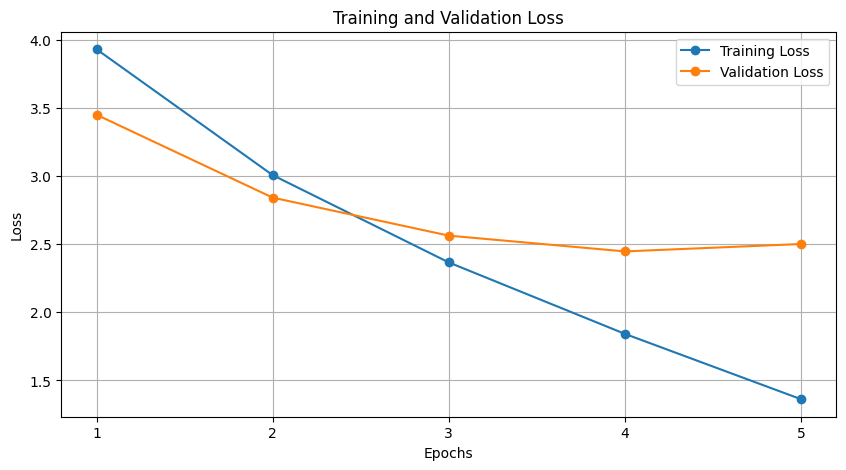

In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop configuration
epochs = 5
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        src = batch['input_ids'].to(device)
        tgt = batch['labels'].to(device)

        # Shift the target input for teacher forcing
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        # Forward pass
        optimizer.zero_grad()
        output = model(src, tgt_input)

        # Reshape and calculate loss
        output = output.view(-1, output.shape[-1])
        tgt_output = tgt_output.contiguous().view(-1)
        loss = criterion(output, tgt_output)

        # Backprop and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)  # Lưu training loss
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {avg_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            src = batch['input_ids'].to(device)
            tgt = batch['labels'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            output = output.view(-1, output.shape[-1])
            tgt_output = tgt_output.contiguous().view(-1)

            loss = criterion(output, tgt_output)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)  
    print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}')

# Plotting the loss function
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, epochs + 1))
plt.legend()
plt.grid()
plt.show()


Recap consolve in case error in display output:

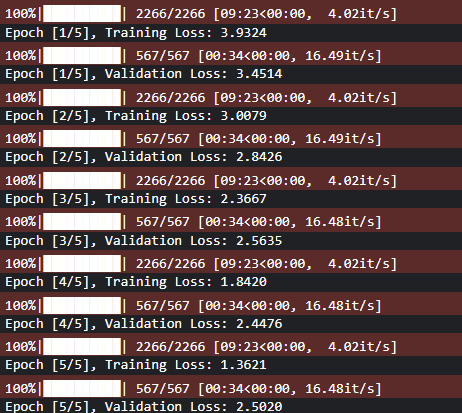

In [122]:
PATH = '/kaggle/working/transformer.pth'
torch.save(model.state_dict(), PATH)

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move model to device

# Function to translate an English sentence to Vietnamese
def translate_sentence(model, sentence, tokenizer, max_len=128):
    model.eval()
    src_tokens = tokenizer.encode(sentence, return_tensors='pt').to(device)  # Ensure tokens are on the correct device

    # Generate translation
    generated_tokens = model.generate(src_tokens, max_len=max_len, start_symbol=tokenizer.cls_token_id)
    translated_tokens = model.decode(generated_tokens)
    
    # Convert token IDs back to words
    translation = tokenizer.decode(translated_tokens, skip_special_tokens=True)
    return translation

english_sentence = "I am a student"
vietnamese_translation = translate_sentence(model, english_sentence, tokenizer)
print(f"English: {english_sentence}")
print(f"Vietnamese: {vietnamese_translation}\n")

english_sentence = "Tea and Coffee"
vietnamese_translation = translate_sentence(model, english_sentence, tokenizer)
print(f"English: {english_sentence}")
print(f"Vietnamese: {vietnamese_translation}\n")

english_sentence = "Coffee"
vietnamese_translation = translate_sentence(model, english_sentence, tokenizer)
print(f"English: {english_sentence}")
print(f"Vietnamese: {vietnamese_translation}\n")

English: I am a student
Vietnamese: iud sinh vien bang

English: Tea and Coffee
Vietnamese: tra

English: Coffee
Vietnamese: cafe

